# SF Crime Analysis

In [2]:
#load libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder


In [579]:
#read dataset
df = pd.read_csv('police-department-incidents.csv')
test = pd.read_csv('police-department-incidents.csv')


## EDA

In [211]:
df.shape

(2215024, 13)

In [5]:
df.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,180362289,VEHICLE THEFT,STOLEN MOTORCYCLE,Tuesday,2018-05-15T00:00:00.000,10:30,SOUTHERN,NONE,700 Block of TEHAMA ST,-122.411912,37.775207,"{'type': 'Point', 'coordinates': [-122.4119120...",18036228907023
1,180360948,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Tuesday,2018-05-15T00:00:00.000,04:14,SOUTHERN,NONE,MARKET ST / SOUTH VAN NESS AV,-122.419258,37.775146,"{'type': 'Point', 'coordinates': [-122.4192578...",18036094864020
2,180360879,OTHER OFFENSES,PAROLE VIOLATION,Tuesday,2018-05-15T00:00:00.000,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,37.757101,"{'type': 'Point', 'coordinates': [-122.4178125...",18036087926150
3,180360879,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Tuesday,2018-05-15T00:00:00.000,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,37.757101,"{'type': 'Point', 'coordinates': [-122.4178125...",18036087965010
4,180360879,OTHER OFFENSES,TRAFFIC VIOLATION,Tuesday,2018-05-15T00:00:00.000,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,37.757101,"{'type': 'Point', 'coordinates': [-122.4178125...",18036087965015


In [37]:
#check time range of this dataset
min(df.Date)
max(df.Date)

#df.Date.max() also works

'2018-05-15T00:00:00.000'

Data is available from 2003 to 2018

In [13]:
#stat summary
df.describe()

,IncidntNum,X,Y,PdId
count,2.215024e+06,2.215024e+06,2.215024e+06,2.215024e+06
mean,1.040728e+08,-1.224229e+02,3.777076e+01,1.040728e+13
std,4.612827e+07,2.983459e-02,4.203596e-01,4.612827e+12
min,3.979000e+03,-1.225136e+02,3.770788e+01,3.979630e+08
25%,6.124170e+07,-1.224332e+02,3.775302e+01,6.124170e+12
50%,1.011558e+08,-1.224166e+02,3.777542e+01,1.011558e+13
75%,1.409256e+08,-1.224069e+02,3.778448e+01,1.409256e+13
max,9.915824e+08,-1.205000e+02,9.000000e+01,9.915824e+13


In [5]:
#similar to str() in R
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215024 entries, 0 to 2215023
Data columns (total 13 columns):
IncidntNum    int64
Category      object
Descript      object
DayOfWeek     object
Date          object
Time          object
PdDistrict    object
Resolution    object
Address       object
X             float64
Y             float64
Location      object
PdId          int64
dtypes: float64(2), int64(2), object(9)
memory usage: 219.7+ MB


### Missing value handling 

In [4]:
df.isnull().sum()

IncidntNum    0
Category      0
Descript      0
DayOfWeek     0
Date          0
Time          0
PdDistrict    1
Resolution    0
Address       0
X             0
Y             0
Location      0
PdId          0
dtype: int64

Only one missing value coming from PdDistrict. We will take a further look

In [5]:
df[df.PdDistrict.isnull()]

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
345394,166018573,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,2016-01-17T00:00:00.000,23:54,NaN,NONE,100 Block of VELASCO AV,-122.413352,37.708202,"{'type': 'Point', 'coordinates': [-122.4133519...",16601857306244


We will replace the Null PdDistrict with 'INGLESIDE', based on the coordinates provided as well as police district data from https://data.sfgov.org/Public-Safety/Current-Police-Districts/wkhw-cjsf

In [580]:
df.PdDistrict.fillna("INGLESIDE", inplace=True)

### Drop Duplicates 

In [581]:
df.drop_duplicates(inplace=True)
#No duplicates in this dataset

### Check Data Distribution

We will firstly look into each column and it's distribution. We would particularly want to explore spatial and temporal distribution. This will also give us an idea of what feature engineering can be done (both derives from existing features, and from external dataset) 

In [9]:
df.Category.value_counts()


LARCENY/THEFT                  480448
OTHER OFFENSES                 309358
NON-CRIMINAL                   238323
ASSAULT                        194694
VEHICLE THEFT                  126602
DRUG/NARCOTIC                  119628
VANDALISM                      116059
WARRANTS                       101379
BURGLARY                        91543
SUSPICIOUS OCC                  80444
MISSING PERSON                  64961
ROBBERY                         55867
FRAUD                           41542
SECONDARY CODES                 25831
FORGERY/COUNTERFEITING          23050
WEAPON LAWS                     22234
TRESPASS                        19449
PROSTITUTION                    16701
STOLEN PROPERTY                 11891
SEX OFFENSES, FORCIBLE          11742
DISORDERLY CONDUCT              10040
DRUNKENNESS                      9826
RECOVERED VEHICLE                8716
DRIVING UNDER THE INFLUENCE      5672
KIDNAPPING                       5346
RUNAWAY                          4440
LIQUOR LAWS 

In [31]:
df.DayOfWeek.value_counts()


Friday       337941
Wednesday    324020
Saturday     320593
Thursday     316156
Tuesday      315135
Monday       306587
Sunday       294592
Name: DayOfWeek, dtype: int64

In [32]:
df.PdDistrict.value_counts()

SOUTHERN      399785
MISSION       300076
NORTHERN      272713
CENTRAL       226255
BAYVIEW       221000
INGLESIDE     194181
TENDERLOIN    191746
TARAVAL       166971
PARK          125479
RICHMOND      116818
Name: PdDistrict, dtype: int64

In [35]:
df.Resolution.value_counts()


NONE                                      1389500
ARREST, BOOKED                             524979
ARREST, CITED                              154789
LOCATED                                     34463
PSYCHOPATHIC CASE                           29185
UNFOUNDED                                   23799
JUVENILE BOOKED                             14158
COMPLAINANT REFUSES TO PROSECUTE             8089
DISTRICT ATTORNEY REFUSES TO PROSECUTE       7955
NOT PROSECUTED                               7720
JUVENILE CITED                               6587
PROSECUTED BY OUTSIDE AGENCY                 5070
EXCEPTIONAL CLEARANCE                        4258
JUVENILE ADMONISHED                          3004
JUVENILE DIVERTED                             694
CLEARED-CONTACT JUVENILE FOR MORE INFO        689
PROSECUTED FOR LESSER OFFENSE                  85
Name: Resolution, dtype: int64

We can do a grouping to turn them into 'Resolved' vs. 'Unresolved'

## Visualizations

Visualizations are stored in a Tableau Dashboard that is published here:

**External Data Added**
  - Police District [Source: DataSF](https://data.sfgov.org/Public-Safety/Current-Police-Districts/wkhw-cjsf)
  - Budget [Source: DataSF](https://data.sfgov.org/City-Management-and-Ethics/Budget/xdgd-c79v)
  - Holiday
  
**Feature Engineering**
  - Hour of day
  - Seasonality (Quarter)
  - Resolution Rate 
  - Resolution type ('Resolved', 'Unresolved')
  - Annual police budget (salary only)

**Key Opportunities**
  - Lunchtime, Friday evening peak, and Sat night has more incidents
  - 'SOUTHERN' district sees higher incident number while lower resolution rate, which requires more attention
  - Non criminal categories, especially 'Theft', saw a significant increase of incident number due to the threshold increase in 2010 in CA
  - Holiday seasons are more calm

## Feature Encoding (Removed)

In [66]:
#lets check correlation matrix
#integerincoding
pd_districts = {'SOUTHERN':0, 'MISSION':1, 'NORTHERN':2, 'CENTRAL':3, 'BAYVIEW':4, 'INGLESIDE':5, 
                'TENDERLOIN':6, 'TARAVAL':7, 'PARK':8, 'RICHMOND':9}

test.PdDistrict.fillna("INGLESIDE", inplace=True)
#option 2 test['PdDistrict'].replace(pd_districts, inplace = True)
test.replace({'PdDistrict':pd_districts},inplace = True)

In [50]:
#Category
data = [test] 

for dataset in data:
    cat_le = LabelEncoder()
    cat_le.fit(dataset['Category'].unique())
    print(list(cat_le.classes_))
    dataset['Category']=cat_le.transform(dataset['Category'])

['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY', 'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE', 'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION', 'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING', 'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING', 'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES', 'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE', 'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES, FORCIBLE', 'SEX OFFENSES, NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE', 'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT', 'WARRANTS', 'WEAPON LAWS']


In [60]:
len(test['Category'].unique())
len(cat_le.classes_)


array([36, 20, 21, 25,  7, 17, 37, 23,  1, 16, 35, 30, 15,  4, 27,  8, 32,
        6, 38, 13, 34, 11, 19, 28, 26,  5, 12, 14,  3, 10,  0,  9, 22, 31,
       29,  2, 18, 24, 33])

In [57]:
#zip to match, then turn them to dict
dict(zip(cat_le.classes_, cat_le.transform(cat_le.classes_)))

{'ARSON': 0,
 'ASSAULT': 1,
 'BAD CHECKS': 2,
 'BRIBERY': 3,
 'BURGLARY': 4,
 'DISORDERLY CONDUCT': 5,
 'DRIVING UNDER THE INFLUENCE': 6,
 'DRUG/NARCOTIC': 7,
 'DRUNKENNESS': 8,
 'EMBEZZLEMENT': 9,
 'EXTORTION': 10,
 'FAMILY OFFENSES': 11,
 'FORGERY/COUNTERFEITING': 12,
 'FRAUD': 13,
 'GAMBLING': 14,
 'KIDNAPPING': 15,
 'LARCENY/THEFT': 16,
 'LIQUOR LAWS': 17,
 'LOITERING': 18,
 'MISSING PERSON': 19,
 'NON-CRIMINAL': 20,
 'OTHER OFFENSES': 21,
 'PORNOGRAPHY/OBSCENE MAT': 22,
 'PROSTITUTION': 23,
 'RECOVERED VEHICLE': 24,
 'ROBBERY': 25,
 'RUNAWAY': 26,
 'SECONDARY CODES': 27,
 'SEX OFFENSES, FORCIBLE': 28,
 'SEX OFFENSES, NON FORCIBLE': 29,
 'STOLEN PROPERTY': 30,
 'SUICIDE': 31,
 'SUSPICIOUS OCC': 32,
 'TREA': 33,
 'TRESPASS': 34,
 'VANDALISM': 35,
 'VEHICLE THEFT': 36,
 'WARRANTS': 37,
 'WEAPON LAWS': 38}

In [68]:
test.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,180362289,36,STOLEN MOTORCYCLE,Tuesday,2018-05-15T00:00:00.000,10:30,0,NONE,700 Block of TEHAMA ST,-122.411912,37.775207,"{'type': 'Point', 'coordinates': [-122.4119120...",18036228907023
1,180360948,20,"AIDED CASE, MENTAL DISTURBED",Tuesday,2018-05-15T00:00:00.000,04:14,0,NONE,MARKET ST / SOUTH VAN NESS AV,-122.419258,37.775146,"{'type': 'Point', 'coordinates': [-122.4192578...",18036094864020
2,180360879,21,PAROLE VIOLATION,Tuesday,2018-05-15T00:00:00.000,02:01,1,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,37.757101,"{'type': 'Point', 'coordinates': [-122.4178125...",18036087926150
3,180360879,21,TRAFFIC VIOLATION ARREST,Tuesday,2018-05-15T00:00:00.000,02:01,1,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,37.757101,"{'type': 'Point', 'coordinates': [-122.4178125...",18036087965010
4,180360879,21,TRAFFIC VIOLATION,Tuesday,2018-05-15T00:00:00.000,02:01,1,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,37.757101,"{'type': 'Point', 'coordinates': [-122.4178125...",18036087965015


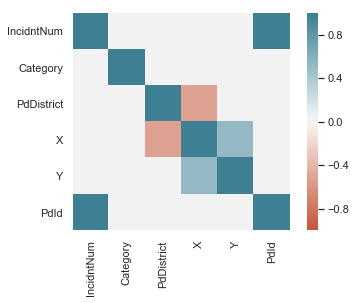

In [69]:

corr = test.corr()
ax = sns.heatmap(corr, vmin =-1, vmax = 1, center = 0, cmap = sns.diverging_palette(20,220,n=200),square = True)

## Time Series

### External dataset

#### a) Holiday

In [10]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()

holidays = cal.holidays(start = df['Date'].min(), end = df['Date'].max())


In [583]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [12]:
df['Holiday'] = df['Date'].dt.date.astype('datetime64').isin(holidays)

#### b) Budget

In [13]:
budget = pd.read_csv('Budget.csv',low_memory=False)

In [14]:
budget.info()
budget.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216259 entries, 0 to 216258
Data columns (total 22 columns):
Fiscal Year                216259 non-null int64
Revenue or Spending        216259 non-null object
Related Govt Unit          216259 non-null object
Organization Group Code    216259 non-null int64
Organization Group         216259 non-null object
Department Code            216259 non-null object
Department                 216259 non-null object
Program Code               216259 non-null object
Program                    216259 non-null object
Character Code             216259 non-null object
Character                  216259 non-null object
Object Code                216259 non-null object
Object                     216259 non-null object
Sub-object Code            216259 non-null object
Sub-object                 216259 non-null object
Fund Type Code             216259 non-null object
Fund Type                  216259 non-null object
Fund Code                  216259 non-nul

(216259, 22)

In [15]:
tot_budget = budget[(budget['Department Code'] == 'POL')&(budget['Character']== 'Salaries')].groupby(['Fiscal Year'])['Budget'].sum().to_frame('tot_budget').reset_index()

In [16]:
tot_budget

,Fiscal Year,tot_budget
0,2010,322576479
1,2011,315116378
2,2012,314266702
3,2013,332475921
4,2014,341287508
5,2015,348097873
6,2016,362642027
7,2017,384654857
8,2018,385567378
9,2019,412380238


In [17]:
tot_budget.to_csv('budget_tot.csv')

#### Create weekly data, then append holiday and budget to it

In [584]:
# add week column

df['week_start'] = df['Date'] - pd.to_timedelta(df['Date'].dt.weekday, unit='D')

df.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,week_start
0,180362289,VEHICLE THEFT,STOLEN MOTORCYCLE,Tuesday,2018-05-15,10:30,SOUTHERN,NONE,700 Block of TEHAMA ST,-122.411912,37.775207,"{'type': 'Point', 'coordinates': [-122.4119120...",18036228907023,2018-05-14
1,180360948,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Tuesday,2018-05-15,04:14,SOUTHERN,NONE,MARKET ST / SOUTH VAN NESS AV,-122.419258,37.775146,"{'type': 'Point', 'coordinates': [-122.4192578...",18036094864020,2018-05-14
2,180360879,OTHER OFFENSES,PAROLE VIOLATION,Tuesday,2018-05-15,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,37.757101,"{'type': 'Point', 'coordinates': [-122.4178125...",18036087926150,2018-05-14
3,180360879,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Tuesday,2018-05-15,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,37.757101,"{'type': 'Point', 'coordinates': [-122.4178125...",18036087965010,2018-05-14
4,180360879,OTHER OFFENSES,TRAFFIC VIOLATION,Tuesday,2018-05-15,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,37.757101,"{'type': 'Point', 'coordinates': [-122.4178125...",18036087965015,2018-05-14


In [585]:
# similarly, add year
df['fisical_year'] = df['Date'].dt.year

In [586]:
# start aggregation
new = df.groupby(['week_start'])['IncidntNum'].count().to_frame('weekly_incidents').reset_index()

In [589]:
new.head()
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 3 columns):
week_start          803 non-null datetime64[ns]
weekly_incidents    803 non-null int64
fisical_year        803 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 18.9 KB


In [588]:
new['fisical_year'] = new['week_start'].dt.year

In [590]:
#add holiday 
from datetime import timedelta
cal = calendar()

holidays = cal.holidays(start = new['week_start'].min(), end = df['week_start'].max()+ timedelta(days=6))

In [591]:
holidays = holidays.to_frame(index = False)

holidays.columns = ['Date']

In [592]:
holidays['week_start'] = holidays['Date'] - pd.to_timedelta(holidays['Date'].dt.weekday, unit='D')

In [593]:
holidays =  holidays.groupby(['week_start'])['Date'].count().to_frame('holiday_count').reset_index()

In [610]:
df1 = df[df['PdDistrict'] == 'SOUTHERN'].groupby(['week_start'])['IncidntNum'].count().to_frame('southern_dist_weekly_incidents').reset_index()

In [611]:
df2 = df[(df['PdDistrict'] == 'SOUTHERN') & (~df['Resolution'].isin(['NONE']))].groupby(['week_start'])['IncidntNum'].count().to_frame('southern_dist_weekly_resolved').reset_index()

In [612]:
df1 = df1.set_index('week_start')
df2 = df2.set_index('week_start')

In [619]:
df1 = df1.shift(1)
df2 = df2.shift(1)
#df2 = df2.shift(1).fillna(0,inplace = True) 

In [622]:
southern = pd.merge(left = df1, right = df2, left_on = 'week_start', right_on = 'week_start', how = 'inner')

In [624]:
#join southern district
new = pd.merge(left = new, right = southern, left_on = 'week_start', right_on = 'week_start', how = 'inner')

In [637]:
final.head()

,week_start,weekly_incidents,fisical_year,southern_dist_weekly_incidents,southern_dist_weekly_resolved,Fiscal Year,tot_budget,holiday_count
0,2002-12-30,2197,2002,NaN,NaN,NaN,NaN,1.0
1,2003-01-06,2849,2003,384.0,198.0,NaN,NaN,0.0
2,2003-01-13,2721,2003,473.0,244.0,NaN,NaN,0.0
3,2003-01-20,2982,2003,411.0,178.0,NaN,NaN,1.0
4,2003-01-27,2999,2003,497.0,247.0,NaN,NaN,0.0


In [627]:
#now join budget & holiday

updated = pd.merge(left = new, right = tot_budget, left_on = 'fisical_year', right_on = 'Fiscal Year', how = 'left')

In [628]:
final = pd.merge(left= updated, right = holidays, left_on = 'week_start', right_on = 'week_start', how = 'left')

In [629]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 803 entries, 0 to 802
Data columns (total 8 columns):
week_start                        803 non-null datetime64[ns]
weekly_incidents                  803 non-null int64
fisical_year                      803 non-null int64
southern_dist_weekly_incidents    802 non-null float64
southern_dist_weekly_resolved     802 non-null float64
Fiscal Year                       437 non-null float64
tot_budget                        437 non-null float64
holiday_count                     153 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 56.5 KB


In [630]:
final.holiday_count.fillna(0, inplace=True)
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 803 entries, 0 to 802
Data columns (total 8 columns):
week_start                        803 non-null datetime64[ns]
weekly_incidents                  803 non-null int64
fisical_year                      803 non-null int64
southern_dist_weekly_incidents    802 non-null float64
southern_dist_weekly_resolved     802 non-null float64
Fiscal Year                       437 non-null float64
tot_budget                        437 non-null float64
holiday_count                     803 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 56.5 KB


In [634]:
# add peak hour count 
friday = df[df['DayOfWeek']=='Friday'].groupby(['week_start'])['IncidntNum'].count().to_frame('friday_incidents').reset_index()



In [635]:
friday = friday.set_index('week_start')
friday = friday.shift(1)

In [638]:
final = pd.merge(left= final, right = friday, left_on = 'week_start', right_on = 'week_start', how = 'left')

In [639]:
final.friday_incidents.fillna(0, inplace=True)

In [640]:
final = final.drop(columns = ['Fiscal Year'])

In [641]:
# add seaonality - using one hot encoding as we also will try regression 
final['quarter'] = final['week_start'].dt.quarter

In [642]:
#one hot encoding
one_hot = pd.get_dummies(final.quarter, prefix='quarter')
final = final.join(one_hot)

In [643]:
final = final.drop(columns  = ['quarter'])

In [644]:
final['tot_budget'] = final['tot_budget']/1000000

In [659]:
#Now check final dataset
final.tail()

,week_start,weekly_incidents,fisical_year,southern_dist_weekly_incidents,southern_dist_weekly_resolved,tot_budget,holiday_count,friday_incidents,quarter_1,quarter_2,quarter_3,quarter_4
798,2018-04-16,2397,2018,485.0,126.0,385.567378,0.0,445.0,0,1,0,0
799,2018-04-23,2395,2018,432.0,113.0,385.567378,0.0,379.0,0,1,0,0
800,2018-04-30,2187,2018,413.0,96.0,385.567378,0.0,364.0,0,1,0,0
801,2018-05-07,1668,2018,482.0,117.0,385.567378,0.0,336.0,0,1,0,0
802,2018-05-14,89,2018,293.0,116.0,385.567378,0.0,0.0,0,1,0,0


In [42]:

min(tot_budget['Fiscal Year'])

2010

##### Since budget only has data from 2010, we will use 2010 - 2016 as training window, 2017 - 2018 as validation.
##### Note that May 2018 data is also abnormal. We will drop May 2018 data as well.

In [646]:
train = final[(final['fisical_year'] >= 2010)&(final['fisical_year'] <= 2016)]


In [647]:
validation = final[(final['fisical_year'] >= 2017) & (final['week_start'] <= '2018-04-30')]

In [648]:
train.shape,
validation.shape
validation.tail()

,week_start,weekly_incidents,fisical_year,southern_dist_weekly_incidents,southern_dist_weekly_resolved,tot_budget,holiday_count,friday_incidents,quarter_1,quarter_2,quarter_3,quarter_4
796,2018-04-02,2356,2018,478.0,127.0,385.567378,0.0,380.0,0,1,0,0
797,2018-04-09,2531,2018,415.0,91.0,385.567378,0.0,366.0,0,1,0,0
798,2018-04-16,2397,2018,485.0,126.0,385.567378,0.0,445.0,0,1,0,0
799,2018-04-23,2395,2018,432.0,113.0,385.567378,0.0,379.0,0,1,0,0
800,2018-04-30,2187,2018,413.0,96.0,385.567378,0.0,364.0,0,1,0,0


#### Stationary Check

In [250]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(train.weekly_incidents, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


ADF Statistic: -2.528276168345844
p-value: 0.1087451203259247
Critial Values:
   1%, -3.448853029339765
Critial Values:
   5%, -2.869693115704379
Critial Values:
   10%, -2.571113512498422


In [251]:

# KPSS Test
result = kpss(train.weekly_incidents, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 1.510130
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [649]:
#indexing 

train= train.set_index('week_start')
train = train.sort_values('week_start')


validation = validation.set_index('week_start')
validation = validation.sort_values('week_start')

In [430]:
train.head()

,weekly_incidents,fisical_year,southern_dist_weekly_incidents,southern_dist_weekly_resolved,tot_budget,holiday_count,friday_incidents,quarter_1,quarter_2,quarter_3,quarter_4
week_start,,,,,,,,,,,
2010-01-04,2441,2010,447,165,322.576479,0.0,356.0,1,0,0,0
2010-01-11,2692,2010,482,185,322.576479,0.0,454.0,1,0,0,0
2010-01-18,2457,2010,380,157,322.576479,1.0,387.0,1,0,0,0
2010-01-25,2487,2010,457,188,322.576479,0.0,373.0,1,0,0,0
2010-02-01,2630,2010,491,229,322.576479,0.0,410.0,1,0,0,0


### Linear Regression

In [145]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [650]:
y_train = train.weekly_incidents
x_train = train.drop(columns = ['weekly_incidents'])

In [651]:
x_test = validation.drop(columns = ['weekly_incidents'])
y_test = validation.weekly_incidents

In [652]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [653]:
coeff_df = pd.DataFrame(lr.coef_, x_train.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
fisical_year,57.759880
southern_dist_weekly_incidents,1.402717
southern_dist_weekly_resolved,-0.459476
tot_budget,-1.915940
holiday_count,-59.595536
friday_incidents,0.667222
quarter_1,22.238511
quarter_2,-10.949569
quarter_3,0.170677
quarter_4,-11.459619


In [654]:
y_pred = lr.predict(x_test)


In [655]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.tail(40)

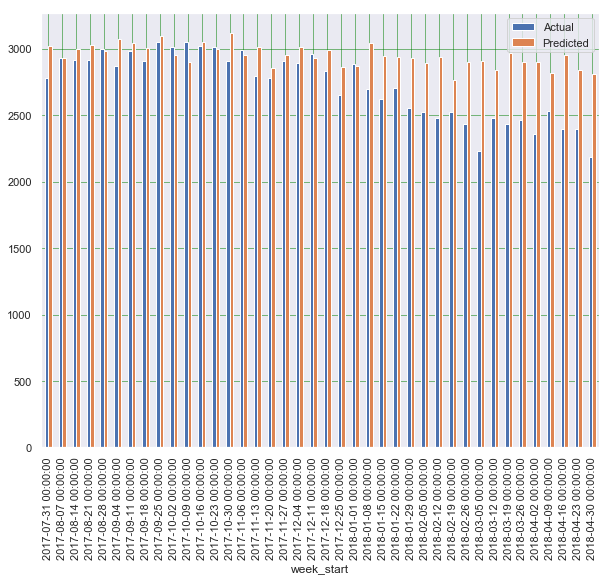

In [656]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [657]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 score: ', r2_score(y_test, y_pred))


Mean Absolute Error: 183.01565532884624
Mean Squared Error: 61002.18536946078
Root Mean Squared Error: 246.98620481610055
R2 score:  -0.023761510727822177


In [261]:
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, x_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

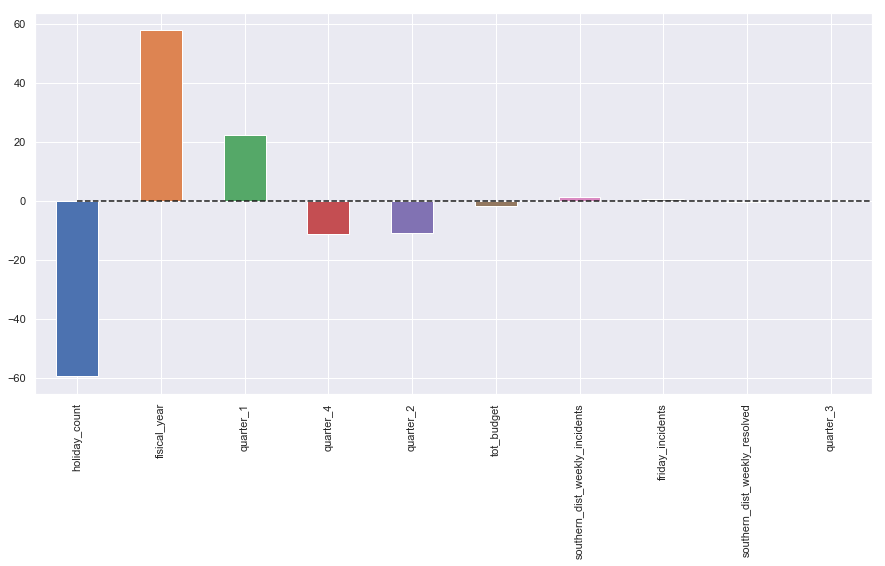

In [658]:
plotCoefficients(lr)

### Linear Regression (With Time Lag)

In [660]:
# Adding the lag of the target variable from 6 steps back up to 24
final2 = final
for i in range(6, 25):
    final2["lag_{}".format(i)] = final2.weekly_incidents.shift(i)

In [661]:
train2 = final2[(final2['fisical_year'] >= 2010)&(final2['fisical_year'] <= 2016)]
validation2 = final2[(final2['fisical_year'] >= 2017)&(final['week_start'] <= '2018-04-30')]

In [662]:
#indexing 

train2= train2.set_index('week_start')
train2 = train2.sort_values('week_start')
train2.head()

validation2 = validation2.set_index('week_start')
validation2 = validation2.sort_values('week_start')

In [663]:
y_train2 = train2.weekly_incidents
x_train2 = train2.drop(columns = ['weekly_incidents'])

In [664]:
x_test2 = validation2.drop(columns = ['weekly_incidents'])
y_test2 = validation2.weekly_incidents

In [665]:
lr = LinearRegression()
lr.fit(x_train2, y_train2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [666]:
coefs = pd.DataFrame(lr.coef_, x_train2.columns)
coefs

,0
fisical_year,33.827220
southern_dist_weekly_incidents,1.215325
southern_dist_weekly_resolved,-0.503534
tot_budget,-1.892645
holiday_count,-64.191493
friday_incidents,0.472418
quarter_1,42.140716
quarter_2,-7.400186
quarter_3,8.825907
quarter_4,-43.566437


In [667]:
y_pred2 = lr.predict(x_test2)


In [668]:
df = pd.DataFrame({'Actual': y_test2, 'Predicted': y_pred2})
df1 = df.tail(40)

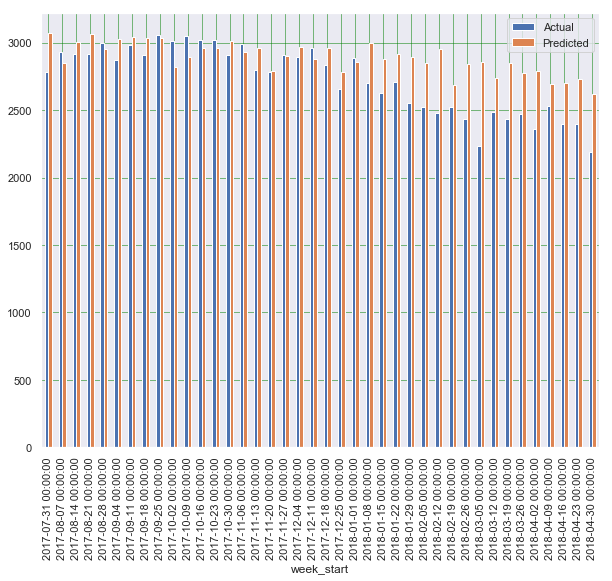

In [669]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [670]:

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test2, y_pred2))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test2, y_pred2))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test2, y_pred2)))
print('R2 score: ', r2_score(y_test2, y_pred2))


Mean Absolute Error: 160.26237859501146
Mean Squared Error: 42799.643502078194
Root Mean Squared Error: 206.88074705510465
R2 score:  0.2817203609194715


In [459]:
#plotCoefficients(lr)

### XGBoost

In [1]:
from xgboost import XGBRegressor 


In [671]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [672]:
x_test = validation.drop(columns = ['weekly_incidents'])
y_test = validation.weekly_incidents

In [673]:
y_pred = xgb.predict(x_test)


In [674]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.tail(40)

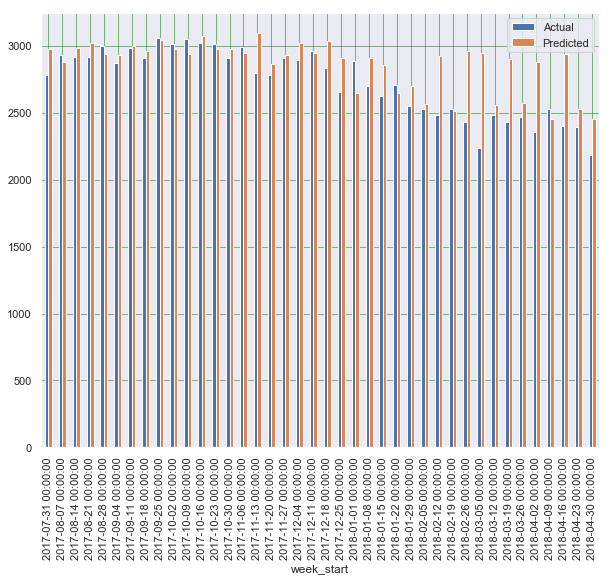

In [675]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [676]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 score: ', r2_score(y_test, y_pred))


Mean Absolute Error: 142.5358851841518
Mean Squared Error: 41313.1556756539
Root Mean Squared Error: 203.2563791757934
R2 score:  0.30666715608167405


### ARIMA

In [468]:
#here we use original, no lag data
final2.head()

,week_start,weekly_incidents,fisical_year,southern_dist_weekly_incidents,southern_dist_weekly_resolved,tot_budget,holiday_count,friday_incidents,quarter_1,quarter_2,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
0,2002-12-30,2197,2002,384,198,NaN,1.0,440.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-01-06,2849,2003,473,244,NaN,0.0,399.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-01-13,2721,2003,411,178,NaN,0.0,444.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-01-20,2982,2003,497,247,NaN,1.0,466.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-01-27,2999,2003,495,250,NaN,0.0,419.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [282]:
data = final[['week_start','weekly_incidents']]

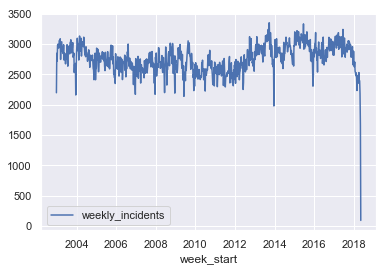

In [283]:
# Normal line plot so that we can see data variation
final.plot.line(x = 'week_start', y = 'weekly_incidents')
plt.show()

In previous lines we already know that the data is non stationary. 

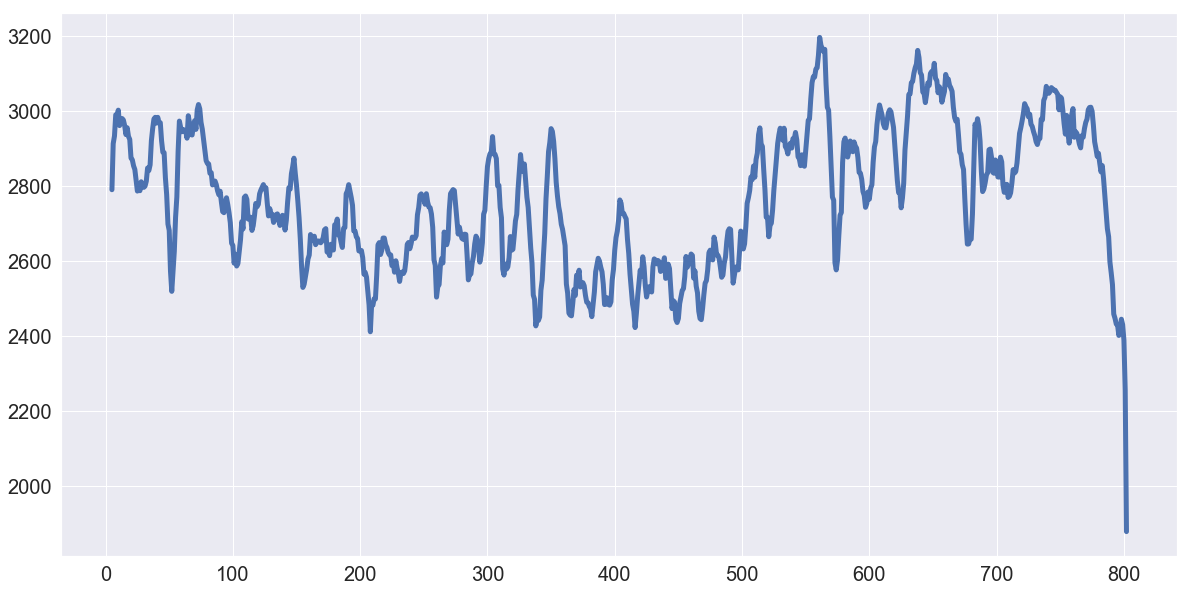

In [284]:
#smoothing - trend analysis
data2 = final['weekly_incidents']
data2.rolling(6).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

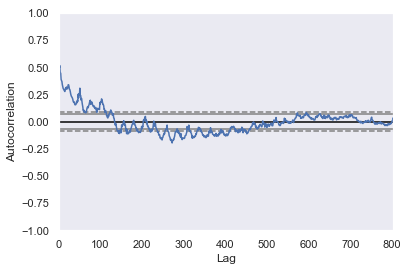

In [285]:
#seasonality
pd.plotting.autocorrelation_plot(final['weekly_incidents'])
plt.show()

In [286]:
data.head()

,week_start,weekly_incidents
0,2002-12-30,2197
1,2003-01-06,2849
2,2003-01-13,2721
3,2003-01-20,2982
4,2003-01-27,2999


In [287]:
#Monthly Trend

data['Month'] = data['week_start'].dt.month


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


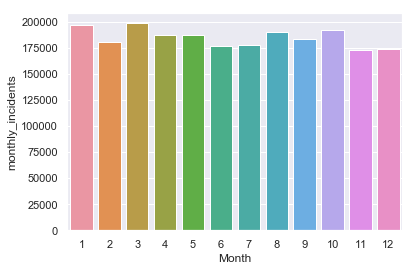

In [288]:
to_plot = data.groupby(data.Month)['weekly_incidents'].sum().to_frame('monthly_incidents').reset_index()
sns.barplot(x = 'Month', y = 'monthly_incidents', data = to_plot)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


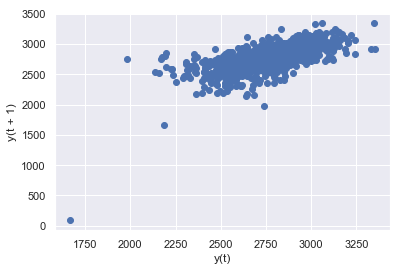

In [289]:
#lag: The curve represents the relation between current time stepp and its previous time step

pd.plotting.lag_plot(final['weekly_incidents'])
plt.show()

Hence, we choose (0,1,0) random walk and seasonal_order being (1,1,1,12) as there is monthly seasonality

In [299]:
train = final[(final['fisical_year'] >= 2010)&(final['fisical_year'] <= 2016)]
arima_train = train[['week_start','weekly_incidents']]

In [300]:
mod = SARIMAX(arima_train['weekly_incidents'], trend='n', order=(0,1,0), seasonal_order=(1,1,1,4))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:                  weekly_incidents   No. Observations:                  365
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 4)   Log Likelihood               -2357.606
Date:                           Sun, 14 Jun 2020   AIC                           4721.213
Time:                                   00:41:28   BIC                           4732.871
Sample:                                        0   HQIC                          4725.848
                                           - 365                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L4        0.1848      0.054      3.404      0.001       0.078       0.291
ma.S.L4       -0.9992      0.528     -1.892

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [302]:
test = final[final['fisical_year'] >= 2017]
arima_test = test[['week_start','weekly_incidents']]

### SARIMA 

In [309]:
from itertools import product                

ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [539]:
train_2 = final[(final['fisical_year'] >= 2010) & (final['fisical_year'] <= 2016)]
arima_train_2 = train_2[['week_start','weekly_incidents']]


In [540]:
arima_train_2= arima_train_2.set_index('week_start')


In [315]:
#an optimization function
from tqdm import tqdm_notebook

def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model= SARIMAX(arima_train_2.weekly_incidents, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [541]:
result_table = optimizeSARIMA(parameters_list, d, D, s)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/anaconda

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarnin

In [542]:
result_table.head()


,parameters,aic
0,"(2, 2, 0, 1)",4403.080437
1,"(2, 2, 1, 1)",4406.553523
2,"(2, 3, 0, 1)",4407.867930
3,"(3, 2, 0, 1)",4408.340050
4,"(2, 3, 1, 1)",4409.033166


In [543]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model= SARIMAX(arima_train_2.weekly_incidents, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                   weekly_incidents   No. Observations:                  365
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 24)   Log Likelihood               -2195.540
Date:                            Sun, 14 Jun 2020   AIC                           4403.080
Time:                                    18:04:38   BIC                           4426.054
Sample:                                01-04-2010   HQIC                          4412.234
                                     - 12-26-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7587      0.221      3.432      0.001       0.325       1.192
ar.L2          0.0438      0.111   

In [324]:
#residual plot
import statsmodels.api as sm
import statsmodels.tsa.api as smt
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

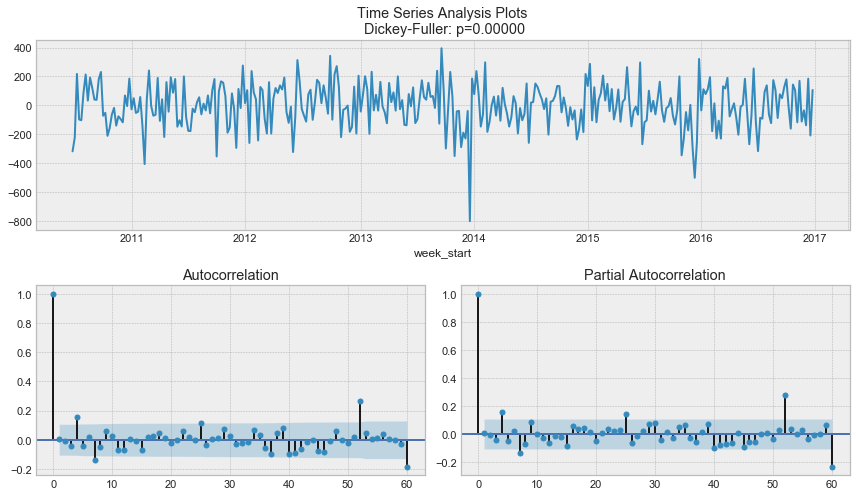

In [544]:
#residuals

tsplot(best_model.resid[24+1:], lags=60)


In [527]:
test_2 = final[(final['fisical_year'] >= 2017)& (final['week_start'] <= '2018-04-30')]
arima_test_2 = test_2[['week_start','weekly_incidents']]
arima_test_2= arima_test_2.set_index('week_start')

In [528]:
y_test = arima_test_2.weekly_incidents

In [529]:
len(y_test)

70

In [687]:
y_pred = best_model.predict(start = 365, end = 500 )

In [556]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.tail(40)

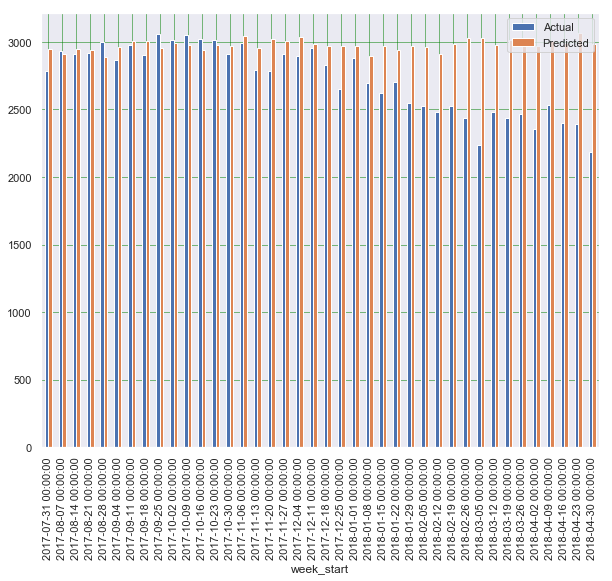

In [557]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [558]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 score: ', r2_score(y_test, y_pred))


Mean Absolute Error: 207.10673347282645
Mean Squared Error: 82355.77964940584
Root Mean Squared Error: 286.976967106083
R2 score:  -0.382125523543168


### Model Comparison

XGBoost has the smallest RMSE in test set. We will do prediction using the best model.

In [677]:
#Retrain the XGBoost model using 2010-2017 data

final_final = final[(final['fisical_year'] >= 2010)]
x_final = final_final.drop(columns = ['weekly_incidents'])
y_final = final_final.weekly_incidents


In [679]:
xgb = XGBRegressor()
xgb.fit(x_final, y_final)


In [573]:
prediction = pd.date_range(start = '2018-05-07',end = '2018-12-31' , freq='W-MON')

In [688]:
df_arima = pd.DataFrame({'Predicted': y_pred})


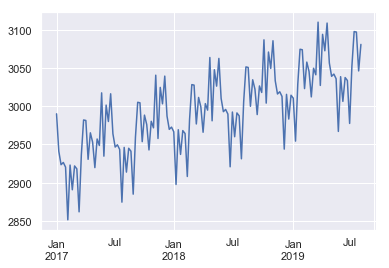

Exception ignored in: <function DMatrix.__del__ at 0x1a2206c6a8>
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/xgboost/core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


In [689]:
# Normal line plot so that we can see data variation
y_pred.plot.line()
plt.show()